In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
import warnings
warnings.filterwarnings("ignore")

### Métricas de avaliação

In [2]:
class ClassificationMetrics:
    
    def accuracy(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        result = ((y_real == y_predicted).sum() / y_real.shape[0])
        return result 
    
    def precision(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        real = y_real.astype(bool)
        pred = y_predicted.astype(bool)
    
        T = real == 1
        F = ~T

        TP = pred[T].sum()
        FP = (~pred[F]).sum()

        result = (TP / (TP + FP))
        return result
    
    def recall(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        real = y_real.astype(bool)
        pred = y_predicted.astype(bool)
        
        T = real == True
        TP = pred[T].sum()
        FN = (~pred[T]).sum()
        
        result = (TP / (TP + FN))
        return result
    
    def f1_score(y_real: np.ndarray, y_predicted: np.ndarray) -> float:
        rec = ClassificationMetrics.recall(y_real, y_predicted)
        prec = ClassificationMetrics.precision(y_real, y_predicted)
        
        result = (2 * (rec * prec) / (rec + prec))
        return result

## Questão 1

In [3]:
data = pd.read_csv("data/californiabin.csv", delimiter="," ,header= None )

X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

### Item A

#### SVM

In [6]:
svc_hiperparameters = {
    'SVC__gamma': [ 2 ** i for i in range(-15, 4) ], 
    'SVC__C': [ 2 ** i for i in range(-5, 16) ]
}

svc_pipeline = Pipeline([('scaler', StandardScaler()), ('SVC', SVC(kernel='rbf'))])
svc_gs = GridSearchCV(svc_pipeline, svc_hiperparameters, cv=cv, return_train_score=True)
svc_gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC', SVC())]),
             param_grid={'SVC__C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4,
                                    8, 16, 32, 64, 128, 256, 512, 1024, 2048,
                                    4096, 8192, 16384, 32768],
                         'SVC__gamma': [3.0517578125e-05, 6.103515625e-05,
                                        0.0001220703125, 0.000244140625,
                                        0.00048828125, 0.0009765625,
                                        0.001953125, 0.00390625, 0.0078125,
                                        0.015625, 0.03125, 0.0625, 0.125, 0.25,
                                        0.5, 1, 2, 4, 8]},
             return_train_score=True)

#### Random Forest

In [6]:
rf_hiperparameters = {
    'RF__n_estimators': list(range(10, 210, 10)),
    'RF__max_depth': [ 2, 4, 6, 8, None ]
}

rf_pipeline = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier())])
rf_gs = GridSearchCV(rf_pipeline, rf_hiperparameters, cv=cv, return_train_score=True)
rf_gs.fit(X_train, y_train)

KeyboardInterrupt: 

### Item B

#### Métricas para SVM

In [8]:
best_svc = svc_gs.best_estimator_
svc_prediction = best_svc.predict(X_test)
print(f"""SVM:

Hiperparâmetros:
{svc_gs.best_params_}

Métricas:
Acurácia: { ClassificationMetrics.accuracy(y_test, svc_prediction) }
F1-score: { ClassificationMetrics.f1_score(y_test, svc_prediction) }
Precisão: { ClassificationMetrics.precision(y_test, svc_prediction) }
Revocação: { ClassificationMetrics.recall(y_test, svc_prediction) }
""")

SVM:

Hiperparâmetros:
{'SVC__C': 16, 'SVC__gamma': 0.125}

Métricas:
Acurácia: 0.8422222222222222
F1-score: 0.6378466557911908
Precisão: 0.5158311345646438
Revocação: 0.8354700854700855



#### Métricas para Random Forest

In [9]:
best_rf = rf_gs.best_estimator_
rf_prediction = best_rf.predict(X_test)
print(f"""Random Forest:

Hiperparâmetros:
{rf_gs.best_params_}

Métricas:
Acurácia: { ClassificationMetrics.accuracy(y_test, rf_prediction) }
F1-score: { ClassificationMetrics.f1_score(y_test, rf_prediction) }
Precisão: { ClassificationMetrics.precision(y_test, rf_prediction) }
Revocação: { ClassificationMetrics.recall(y_test, rf_prediction) }
""")

Random Forest:

Hiperparâmetros:
{'RF__max_depth': None, 'RF__n_estimators': 150}

Métricas:
Acurácia: 0.8722222222222222
F1-score: 0.6464485235434956
Precisão: 0.5159235668789809
Revocação: 0.8653846153846154



#### Curvas ROC e Precision Recall

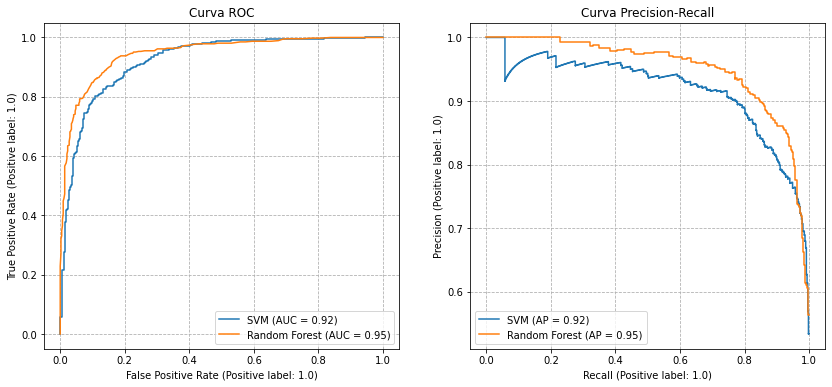

In [10]:
classifiers = {
  "SVM": best_svc,
  "Random Forest": best_rf
}

_, [roc_ax, pr_ax] = plt.subplots(1, 2, figsize=(14, 6))

for name, alg in classifiers.items():
    plot_roc_curve(alg, X_test, y_test, ax=roc_ax, name=name)
    plot_precision_recall_curve(alg, X_test, y_test, ax=pr_ax, name=name)

roc_ax.set_title('Curva ROC')
pr_ax.set_title('Curva Precision-Recall')

roc_ax.grid(linestyle='--')
pr_ax.grid(linestyle='--')